In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp
import rospy

device = torch.device("cpu")


In [44]:
model = torch.load('../models/seggs_v1.pt', map_location=torch.device('cpu'))


In [45]:
im_dir = '../test16'
image = Image.open(im_dir+'.png')
image_np = np.array(image)  # Convert image to a numpy array
transform = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)  # Resize image if needed
augmented = transform(image=image_np)  # Pass the numpy array as a named argument

augmented_image = augmented['image']  # Retrieve the augmented image

# Convert image to tensor and normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
image_tensor = t(augmented_image)



In [46]:
model.eval()
with torch.no_grad():
    # Convert the augmented image to a PyTorch tensor
    image_tensor = t(augmented_image).unsqueeze(0)  # Add batch dimension

    # Move the tensor to the device (CPU or GPU)
    image_tensor = image_tensor.to(device)

    # Make predictions
    output = model(image_tensor)

    # Process the output as needed
    pred_mask = torch.argmax(output, dim=1).squeeze(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


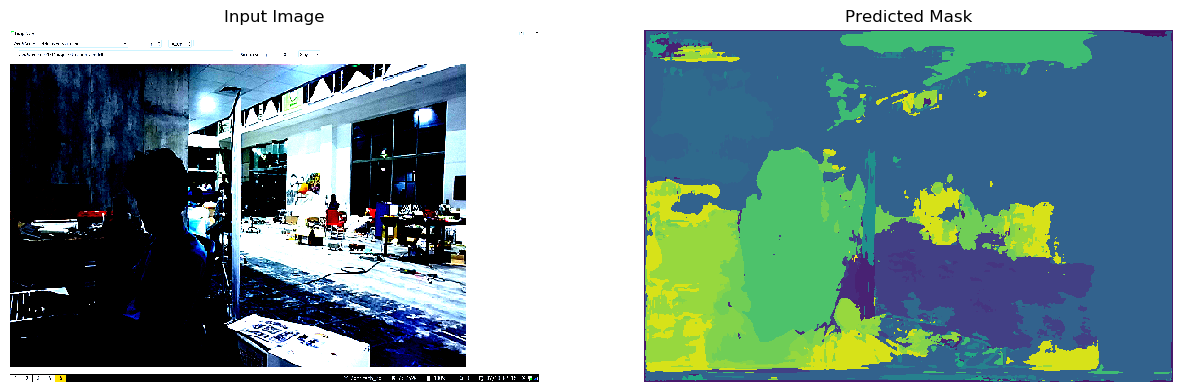

In [47]:
# import matplotlib.pyplot as plt

# # Load and preprocess the input image (image variable from previous steps)
# image = Image.open('path_to_your_image.jpg')
# transform = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)  # Resize image if needed
# image = transform(image)

# # Convert image to tensor and normalize
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
# image = t(image)

# # Make predictions
# model.eval()
# with torch.no_grad():
#     image = image.unsqueeze(0)  # Add batch dimension
#     image = image.to(device)   # Move to GPU if available
#     output = model(image)
#     pred_mask = torch.argmax(output, dim=1).squeeze(0)

# Visualize the results
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 7))

# Convert the augmented image to a PyTorch tensor
image_tensor = t(augmented_image)

# Plot the input image
ax1.imshow(image_tensor.permute(1, 2, 0).cpu())  # Convert tensor to image format (H, W, C)
ax1.set_title('Input Image')
ax1.axis('off')

# Plot the predicted mask
ax3.imshow(pred_mask.cpu())
ax3.set_title('Predicted Mask')
ax3.axis('off')

# fig.savefig('../zed_mask.png')

plt.show()




In [48]:
# Convert the PyTorch tensor to a numpy array
pred_mask_np = pred_mask.cpu().numpy()

# Save the image using cv2.imwrite
cv2.imwrite(im_dir+"_mask.png", pred_mask_np)

True